# ACSE-7 (Optimisation & Inversion) <a class="tocSkip"></a>

## Coursework part B <a class="tocSkip"></a>

Part B of the coursework covers lectures 2-7. The completion time should be roughly that of part A and part C combined.

<div class="optional">
Answers are highlighted in blue.

<font size="1pt">Some $\LaTeX$ definitions hidden in this cell (double-click to reveal)</font>
$
\newcommand\vec[1]{\boldsymbol{\mathrm{#1}}}
\newcommand\mat[1]{\underline{\mathbf{#1}}}
\newcommand\R{\mathbb{R}}
\newcommand\vlam{\boldsymbol{\lambda}}
$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
# the following allows us to plot triangles indicating convergence order
#from mpltools import annotation
# scipy's optimization
import scipy.optimize as sop
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spl

# font sizes for plots
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

In [3]:
%%html
<style>
a.definition {
    color: blue;
    font-style: italic;
    font-weight: bold;
}
div.optional {
    display: block;
    background-color: #f0f8ff;
    border-color: #e0f0ff;
    border-left: 5px solid #e0f0ff;
    padding: 0.5em;
}
</style>

## From Poisson to Diffusion Equation <a class="tocSkip"/></a>

In the lectures, we have used a finite difference discretisation of Poisson's equation in two dimensions:

$$
  -\frac{\partial^2 u(x,y)}{\partial x^2} - \frac{\partial^2 u(x,y)}{\partial y^2} = f(x,y)
$$

with a Finite Difference discretisation given by:


$$ \frac{-u_{i-1} + 2u_{i} -u_{i+1}}{\Delta x^2} + \frac{-u_{i-N_x} + 2u_{i} - u_{i+N_x}}{\Delta y^2} = f_i $$

where we assume a computational grid of $N_y$ rows and $N_x$ columns, giving $n=N_x\cdot N_y$ grid points. The grid values $u_i$ are numbered row by row. The values $u_{i-1}$ and $u_{i+1}$ refer to the values to the left and right of $u_i$ respectively, whereas $u_{i-N_x}$ and $u_{i+N_x}$ refer to value in the row above and below. We will assume $\Delta y=\Delta x$. In matrix form we may write

$$
  \mat K \vec u = \vec f
$$

with for each row $i$ associated with a grid point in the interior (away from the boundary):

$$
  K_{i,i} = \frac{4}{\Delta x^2}, \text{ and }
  K_{i,i-N_x} = K_{i,i-1} = K_{i,i+1} = K_{i,i+N_x} = -\frac 1{\Delta x^2}
$$

For the boundary rows, we imposed Dirichlet boundary conditions, and we stated, without proof, that the resulting matrix is Symmetric Positive Definite.

# Question B1

* What is your recommendation for a Krylov Subspace method to solve this linear system. Describe in one or two sentences why this method requires the matrix to be SPD.

***

<div class="optional">
The most optimal Krylov Subspace method to solve this linear system is Conjugate Gradient [1]. The SPD requirement for $\mat K$  ensures that there is a single minimum in each subspace. As such, A-orthogonality is preserved, which is equivalent to saying that $\vec x^{(k+1)}$ is chosen to be the closest point to the solution $\vec x^*$ (there is a unique point $\vec x^{(k+1)}$ that minimises their A-norm) [2].
</div>

# Question B2


Note that for the rows associated with interior points, we have

$$
  \sum_{j=1}^n K_{ij} = 0
$$

i.e. the sum of the entries in each interior row is zero. If we apply Neumann (instead of Dirichlet) boundary conditions, the same is true for all rows: both boundary and interior rows sum to zero.

* Is the matrix with Neumann boundary condition still Symmetric Positive Definite? **Hint:** consider a vector $\vec v$ whose values are all the same: $v_i=C$ for all $i$ with some constant $C$, and compute $\vec v^T\mat K\vec v$. Assuming the matrix is symmetric, and that for all other vectors $\vec v$ we still have $\vec v^T\mat K\vec v\gt 0$, what other term *does* apply to this matrix?

***

<div class="optional">
The new matrix $\mat K$ has a non-empty null space, so it is singular. If the system satisfies the compatibility condition [4], it is **Symmetric Positive Semi-Definite** (as opposed to SPD). Given a vector $\vec v$ whose values are all the same ($v_i=C$) for all $i$ with some constant $C$, and the matrix $\mat K$ of the discretised Poisson equation with Neumann conditions,  the following is true:

$$\vec v^T\mat K\vec v = 0$$ 

A Positive Semi-Definite matrix $\mat K$ satisfies that  $\vec v^T\mat K\vec v \geq 0 $ (as opposed to the more strict condition for Positive Definiteness $\vec v^T\mat K\vec v \gt 0 $) [3]. 

Note that the matrix $\mat K$ becomes symmetric after halving the equations for the boundary conditions. 

This is checked in the snippet of code below.

In [4]:
import numpy as np
#Define constant to fill vector - Regardless of value, vtKv = 0 
#Given matrices below
C = 3

#1D case
v = np.array([C, C, C, C])
K = np.array([[1, -1, 0, 0], [-1, 2, -1, 0], [0, -1, 2, -1], [0, 0, -1, 1]])
print(K)
print("The product vt K v = {}  for a vector of constants (1D attempt)".format(v@K@v))
print("The sum of all the elements in the matrix is {} (1D attempt)".format(K.sum()))
print("Is the matrix symmetric? (K = K.t?) (1D attempt): {} \n".format(np.allclose(K, K.T,)))

#2D case 
K = 4*np.eye(9) - np.eye(9, k=1) - np.eye(9, k=3) - np.eye(9, k=-1) - np.eye(9, k=-3)
#K[0, 1] = -4; K[-1, -2] = -4; K[0, 3] = -2; K[-1, -4] = -2
K[0, 1] = -2; K[1, 0] = -2; K[-1, -2] = -2; K[-2, -1] = -2; K[0, 0] = 2; K[-1, -1] = 2
v = C*np.ones(9)
print(K)
print("The product vt K v = {}  for a vector of constants (2D attempt)".format(v@K@v))
print("The sum of all the elements in the matrix is {} (2D attempt)".format(K.sum()))
print("Is the matrix symmetric? (K = K.t?) (2D attempt): {} \n".format(np.allclose(K, K.T,)))

[[ 1 -1  0  0]
 [-1  2 -1  0]
 [ 0 -1  2 -1]
 [ 0  0 -1  1]]
The product vt K v = 0  for a vector of constants (1D attempt)
The sum of all the elements in the matrix is 0 (1D attempt)
Is the matrix symmetric? (K = K.t?) (1D attempt): True 

[[ 2. -2.  0. -1.  0.  0.  0.  0.  0.]
 [-2.  4. -1.  0. -1.  0.  0.  0.  0.]
 [ 0. -1.  4. -1.  0. -1.  0.  0.  0.]
 [-1.  0. -1.  4. -1.  0. -1.  0.  0.]
 [ 0. -1.  0. -1.  4. -1.  0. -1.  0.]
 [ 0.  0. -1.  0. -1.  4. -1.  0. -1.]
 [ 0.  0.  0. -1.  0. -1.  4. -1.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  4. -2.]
 [ 0.  0.  0.  0.  0. -1.  0. -2.  2.]]
The product vt K v = 0.0  for a vector of constants (2D attempt)
The sum of all the elements in the matrix is 0.0 (2D attempt)
Is the matrix symmetric? (K = K.t?) (2D attempt): True 



<div class="optional">
    
The matrix $\mat K$ has been derived using ghost points [4]. As such, the boundary values have been included in the matrix. In the 1D case, this results in a matrix of size $(n+1)*(n+1)$ rather than $(n*n)$ (as in the Dirichlet BC case). The equations for the boundary have been halved to preserve symmetry [5]. 

# Question B3


By adding a time derivative, we can turn this PDE into the diffusion equation

$$
  \frac{\partial u(x,y,t)}{\partial t} - m \frac{\partial^2 u(x,y,t)}{\partial x^2} - m\frac{\partial^2 u(x,y,t)}{\partial y^2} = 0
$$

with diffusion coefficient $m$.

With an implicit time integration (backward Euler) the discrete equation looks like:
    
$$ 
\frac{u_i^{k+1} - u_i^k}{\Delta t} +
m\frac{-u_{i-1}^{k+1} + 2u_{i}^{k+1} -u_{i+1}^{k+1}}{\Delta x^2} + m\frac{-u_{i-N_x}^{k+1} + 2u_{i}^{k+1} - u_{i+N_x}^{k+1}}{\Delta y^2} = 0 $$

where the superscript ${}^{k+1}$ refers to the solution at the end of the timestep, and ${}^k$ to the value at the beginning of the timestep.

After multiplying all terms with $\Delta t$, we can write this discretisation as a linear system

$$
  \mat A \vec u^{k+1} = \vec u^k
$$

where the matrix $\mat A$ is given by

$$
  \mat A = \mat I + m~\Delta t~\mat K
$$

with identity matrix $\mat I$, and $\mat K$ the same matrix as we used for Poisson's equation above with Neumann conditions.

* Using what you already know about $\mat K$, proof that $\mat A$ is Symmetric Positive Definite.

***

<div class="optional">
The following is known about the matrixes $\mat I$ and $\mat K$:
- The identity matrix $\mat I$ is SPD: $\vec v^T\mat I\vec v \gt 0 $ 
- The matrix $ m~\Delta t~\mat K$ is Symmetric Positive Semi-Definite: $\vec v^T (m~\Delta t~\mat K)\vec v \geq 0$ (note that $ m~\Delta t$ is a scalar and does not change the type of matrix).

As such, the following is true (given any non-zero $\vec v$):
$$    \mat A = \mat I + m~\Delta t~\mat K =\vec v^T\mat I\vec v + \vec v^T (m~\Delta t~\mat K)\vec v \gt 0 $$
This proves that $\mat A$ must be Positive Defnite.

On the other hand, it is stated without proof that  the addition of two symmetric matrixes results in a symmetric matrix. 

Since $\mat I$ and $ m~\Delta t~\mat K$ are both symmetric (as proved in Question B2), $\mat A$ must be symmetric. 

Therefore, matrix $\mat A$ must be Symmetric Positive Definite. 

This is checked in the snipped of code below.

In [5]:
#1D case
v = np.array([C, C, C, C])
I = np.eye(4)
m = 2
dt = 1e-1
mdtK = m*dt*np.array([[1, -1, 0, 0], [-1, 2, -1, 0], [0, -1, 2, -1], [0, 0, -1, 1]])
K = mdtK + I
print(K)
print("The product vt K v = {}  for a vector of constants (1D attempt)".format(v@K@v))
print("The sum of all the elements in the matrix is {} (1D attempt)".format(K.sum()))
print("Is the matrix symmetric? (K = Kt?) (1D attempt): {} \n".format(np.allclose(K, K.T,)))

[[ 1.2 -0.2  0.   0. ]
 [-0.2  1.4 -0.2  0. ]
 [ 0.  -0.2  1.4 -0.2]
 [ 0.   0.  -0.2  1.2]]
The product vt K v = 36.0  for a vector of constants (1D attempt)
The sum of all the elements in the matrix is 4.0 (1D attempt)
Is the matrix symmetric? (K = Kt?) (1D attempt): True 



# Question B4

* We consider the use of dense vs. sparse matrices in solving this system. We use the Conjugate Gradient method to solve the linear system above on a series of computational grids where we increase the resolution and thus the number of grid points $n=N_x\cdot N_y$. We record the average time the CG method takes to perform a single iteration with the results displayed in the graph below. Describe the difference in terms of scaling for the case with dense matrices and the case with sparse matrices, and explain the reason why these differences can be observed. You only need to describe the asymptotic behaviour.

<img src='graph1.png'></img>

***

<div class="optional">
The plot above shows the time complexity of a single CG iteration. The dense solver scales quadratically ($𝑂(𝑛^2)$), and the sparse one does so linearly ($𝑂(𝑛)$) -- the sparse solver is increasingly faster for larger domains. 

The complexity of a direct solver for SPD systems depends on the properties of the problem. The most expensive operation in a CG iteration is the matrix-vector multiplication, where empty entries in the matrix do not contribute to the product.  A matrix is considered sparse if most of its elements are zero [6].  This feature is exploited by sparse algorithms, such as the sparse version of CG depicted above.


# Question B5

* As a stopping criterion we use a relative tolerance $\epsilon_{\text{rel}}=10^{-5}$. In the next two figures, we show the overall time for the Conjugate Gradient algorithm to converge with that criterion, and the number of iterations it takes. Only the results with a sparse matrix are shown. Again describe and explain the asymptotic behaviour of both graphs. You do not need to explain the specific value of the~ slope of 0.5 in the right-hand figure. Given that we can observe a slope of 0.5 however, what is your expectation of the scaling between the condition number of the matrix and $n$?

<img src="graph2.png"></img>

***

<div class="optional">
The left figure shows how as 𝑛 is increased, the time it takes to reach the desired accuracy increases more than linearly with  𝑛. This is a result of an increased number of iterations, as seen in the right figure. The slope of 1.5 of the curve in the left can be thought of as the combination of the order of convergence of sparse CG from Question B4 and the increased number of iterations shown in the figure in the right. The cost per iteration is expected to scale linearly with $n$ (as seen in [1]), as expected for sparse matrices. 

The condition number of a matrix is defined as the ratio between its largest and smallest eigenvalues [7]. As shown in [8], the condition number of a matrix increases linearly as 𝑛 does. The increases in the condition number of the matrix as a function of increases in n is as shown in Fig. 3 of [9] (for CG).

Ill-conditioned matrices result in high condition numbers as n is increased. If the matrix is well-conditioned (small condition number), an iterative method converges. Otherwise (ill-conditioned, high condition number), it diverges. 

Furthermore, in the case of well-conditioned matrices, the bigger the size of a matrix is, the slower the methods
approach the correct solution’s value. For ill-conditioned matrices, the bigger the size of a matrix is (a bigger
condition number thereby), the faster the iterative process diverges. The right figure suggests that the matrix used is well-conditioned and that it therefore has a small condition number. 
  
Preconditioning techniques help reduce the condition number of the matrix.

# Question B6

* We also measured the computational time for solving the linear system with a sparse direct method (not shown). We notice that the scaling of the computational time with the problem size $n$ was worse that linear. Explain why this is to be expected. Do you expect the scaling to be better, the same, or even worse when solving the same equation in three dimensions? Explain why.

***

<div class="optional">
    
As described in [1]:

After several operations of a sparse direct method, the matrix will acquire new nonzero entries (fill-in). As such, the matrix starts becoming dense and the cost converges to that for dense matrices. The amount of work required by a solver is directly related to the amount of fill-in. 

The savings that arise for using sparse storage format depends a lot on the type of problem. The degree of fill-in increases as the dimensionality of the problem grows. As such, there are more savings for problems based on a 2D grid than problems based on a 3D grid. For many 2D discretised problems, direct methods can be competitive, but in 3D discretisations iterative methods are typically much more efficient.

# Diffusion Equation as Image Filter (background section - no question) <a class="tocSkip"></a>
The diffusion equation has many applications uch as the dispersal of microparticles through random motion (Brownian motion), the spread of a disolved substance, e.g. a pollutant in a fluid, or the spread of heat. We can also use it as a method to apply a blur effect to a photo.

First we read in a familiar looking photo:

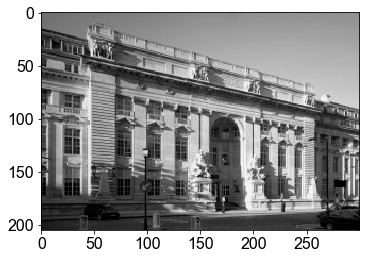

In [6]:
img = plt.imread("RSM-BW-300x205.png")
plt.imshow(img, cmap='gray');

The code to assemble the matrix $\mat A$ is given by:

In [7]:
def K_matrix(Nx, Ny, delta_x=1.0):
    """Assemble discrete Poisson matrix K
    
    Nx, Ny: number of gridpoint in x and y directions
    delta_x: grid distance
    """
    n = Ny * Nx
    K = sp.eye(n)*4  # main diagonal with the value 4
    K -= sp.eye(n, k=1)  # connections to grid point on the right
    K -= sp.eye(n, k=-1)  # connection to the left
    K -= sp.eye(n, k=Nx) # connection to grid point below
    K -= sp.eye(n, k=-Nx)  # connection above
    K = K / (delta_x)**2  # divide all entries by dx^2
        
    return K

def A_matrix(Nx, Ny, m, delta_t=1.0, delta_x=1.0):
    """Assemble discrete timestepping matrix A for diffusion equation
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient
    delta_t: time step
    delta_x: grid distance
    """
    n = Ny * Nx
    K = K_matrix(Nx, Ny, delta_x)
    A = sp.eye(n) + m * delta_t * K
        
    return A

So that a simple timestepping model takes the form:

In [8]:
def diffusion_model(Nx, Ny, m, u0, Nt, delta_t=1.0, delta_x=1.0):
    """Solve diffusion equation and return solution in final timestep
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient
    u0: initial condition
    Nt: number of timesteps
    delta_t: time step
    delta_x: grid distance
    """

    A = A_matrix(Nx, Ny, m, delta_t=delta_t, delta_x=delta_x)
    u = u0
    for i in range(Nt):
        u = spl.spsolve(A, u)  # solve using sparse direct solver
    return u

In the rest of this coursework, we simply assume a fixed value for $\Delta x=1$, and also a timestep of $\Delta t=1$. The domain is assumed to be $[0,L]\times [0,H]$ with length $L=N_x\Delta x=N_x$ and height $H=N_y\Delta x=N_y$. The number of timesteps is given by $N_t$, and in the examples kept fixed at $N_t=5$, and we assume that the time $t$ runs between 0 and $T=N_t\Delta t=N_t$.

The code below shows how the diffusion model can be applied to a black and white photo. Note that we need to flatten the `img` array, which has a shape of $N_y\times N_x$, to a flat array `u` with length $n=N_x\cdot N_y$:

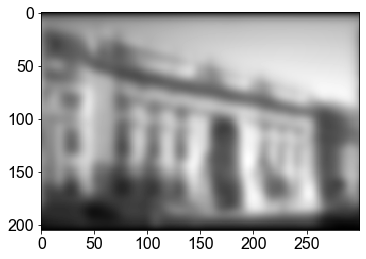

In [9]:
Ny, Nx = img.shape
Nt = 5
m = 3.14159  # what value did we use ??? ## calculated later on
u0 = img.flatten()
u1 = diffusion_model(Nx, Ny, m, u0, Nt)
img1 = u1.reshape(Ny, Nx)
plt.imshow(img1, cmap='gray')
np.save('rsm-blurred.npy', img1)

# Question B7

## Inversion for Diffusion Coefficient <a class="tocSkip"/></a>
After applying the diffusion model, we have forgotten what value of the diffusion coefficient $m$ we have used. We do however still have the original photo that was used which served as the initial condition $u_{\text{ic}}$, and the blurred photo obtained from the last timestep value of $u$, which we have stored as $u_{\text{end}}$ (in the file `rsm-blurred.npy`). We therefore consider the following PDE-constrained optimisation problem:

$$
  \text{minimize } f(u, m) = \int \left(u(x, y, T) -u_{\text{end}}(x, y, T)\right)^2 \mathrm{d}x\mathrm{d}y
$$

subject to the PDE constraint:

$$
  g(u,m) = \begin{pmatrix}
    \frac{\partial u(x,y,t)}{\partial t} -m\frac{\partial^2 u(x,y,t)}{\partial x^2} - m\frac{\partial^2 u(x,y,t)}{\partial y^2}  \\
    u(x, y, 0) - u_{\text{ic}}(x, y) \\
    \frac{\partial u(x,y,t)}{\partial x}  \\
    \frac{\partial u(x,y,t)}{\partial y} 
  \end{pmatrix}
  =
  \begin{pmatrix} 
  \phantom{\frac{\partial^2}{\partial x}} 0 \phantom{\frac{\partial^2}{\partial x}} \\
  \phantom{\frac{\partial u}{\partial x}} 0 \phantom{\frac{\partial u}{\partial x}} \\
  \phantom{\frac{\partial u}{\partial x}} 0 \phantom{\frac{\partial u}{\partial x}} \\
  \phantom{\frac{\partial u}{\partial x}} 0 \phantom{\frac{\partial u}{\partial x}} 
  \end{pmatrix}
  \begin{array}{l}
\text{ for } (x,y)\in [0,L]\times[0,H], t \in [0,T] \phantom{\frac{\partial^2}{\partial x}} \\
\text{ for } (x,y)\in [0,L]\times[0,H] \phantom{\frac{\partial u}{\partial x}} \\
    \text{ for } x=0\text{ or x=L, and } y\in [0,H], t \in [0,T] \phantom{\frac{\partial u}{\partial x}} \\
    \text{ for } y=0\text{ or y=H, and } x\in [0,L], t \in [0,T]
  \end{array}
$$

* We decide to use the tangent-linear approach to compute the gradient of the reduced functional. Consider a perturbation $\delta m$ in the diffusion coefficient $m$, show that the resulting perturbation $\delta u(x,y,t)$ to the solution $u(x,y,t)$ satisfies the following PDE:

$$
      \frac{\partial \delta u(x,y,t)}{\partial t} -m\frac{\partial^2 \delta u(x,y,t)}{\partial x^2} - m\frac{\partial^2 \delta u(x,y,t)}{\partial y^2} =
      \delta m\frac{\partial^2 u(x,y,t)}{\partial x^2} + \delta m\frac{\partial^2 u(x,y,t)}{\partial y^2}      
$$

with initial condition

$$
  \delta u(x,y,0) = 0
$$

and boundary conditions

\begin{align*}
    \frac{\partial \delta u(x,y,t)}{\partial x} &= 0 & \text{ for } x=0\text{ or x=L, and } y\in [0,H] \\
    \frac{\partial \delta u(x,y,t)}{\partial y} &= 0 &
    \text{ for } y=0\text{ or y=H, and } x\in [0,L]
\end{align*}

***

<div class="optional">
The tangent linear approach can be used to linearise a PDE. A perturbation $\delta m$ in $m$ results in a perturbation $\delta u$ to the solution $u$, leading to the tangent linear equation. It can be described as in [10]:


$$
  \frac{\partial g(u(m), m)}{\partial u}\delta u = -\frac{\partial g(u(m), m)}{\partial m}\delta m
$$

Firstly, the LHS of this expression is calculated:

$$
  \frac{\partial g(u, m)}{\partial u} \delta u = \begin{pmatrix}  
  \frac{\partial \delta u(x,y,t)}{\partial t} -m\frac{\partial^2 \delta u(x,y,t)}{\partial x^2} - m\frac{\partial^2 \delta u(x,y,t)}{\partial y^2}\\
  \delta u(x,y,0) \\
  \frac{\partial \delta u(x,y,t)}{\partial x}  \\
  \frac{\partial \delta u(x,y,t)}{\partial y}
  \end{pmatrix}
$$
Similarly, the RHS is derived as: 
$$
  \frac{\partial g(u, m))}{\partial m} \delta m = \begin{pmatrix}  
  \delta m\frac{\partial^2 u(x,y,t)}{\partial x^2} + \delta m\frac{\partial^2 u(x,y,t)}{\partial y^2} \\
  0 \\
  0 \\
  0
  \end{pmatrix}
$$

The equations above correspond to those in the question: The PDE constraint, the initial condition and the two boundary conditions. 

# Question B8



Note that the PDE for $\delta u$ is very similar to the PDE for $u$, except for the additional right-hand side term. We can therefore implement it using

$$
  \mat A \vec{\delta u}^{k+1} = \vec{\delta u}^k - \Delta t~\delta m~\mat K\vec u^{k+1}
$$

where $\vec{\delta u}^{k+1}$ and $\vec{\delta u}^k$ are the numerical solutions for $\delta u$ at the end and beginning of the timestep, and $\vec{u}^{k+1}$ is the numerical solution for $u$ at the end of timestep $k$, calculated as before. The code is given by:

In [10]:
def tangent_linear_model(Nx, Ny, kappa, u0, Nt, delta_t=1.0, delta_x=1.0, delta_m=1.0):
    """Solve tangent linear model based on perturbation in diffusion coefficient.
    Return perturbation in final timestep solution
    
    Nx, Ny: number of gridpoint in x and y directions
    u0: initial condition
    Nt: number of timesteps
    delta_t: time step
    delta_x: grid distance
    delta_m: perturbation in diffusion coefficient m. Set to 1 to compute gradient (see explanation below)
    """

    K = K_matrix(Nx, Ny, delta_x=delta_x)
    A = A_matrix(Nx, Ny, kappa, delta_t=delta_t, delta_x=delta_x)
    u = u0
    du = np.zeros_like(u)  # initial condition for perturbation du
    for i in range(Nt):
        u = spl.spsolve(A, u)  # solve u as before
        du = spl.spsolve(A, du-delta_t*delta_m*(K @ u))  # solve perturbation du
    return du

Using the `diffusion_model` code we can compute the solution $\vec u(m)$ for any value  of the diffusion coefficient $m$, and using the `tangent_linear_model` function we can compute the derivative $\mathrm{d}\vec u(m)/\mathrm{d}m$ by setting $\delta m=1$:

$$
  \delta u = \frac{\mathrm{d}\vec u(m)}{\mathrm{d}m} \delta m
$$

In [11]:
img = plt.imread("RSM-BW-300x205.png")
Ny, Nx = img.shape
Nt = 5
u0 = img.flatten()

def u(m):
    """Solve diffusion equation using diffusion coefficient m. 
    Keep all other inputs fixed (Nx, Ny, delta_x=1, Nt=5, etc)"""
    u1 = diffusion_model(Nx, Ny, m, u0, Nt)
    return u1

def dudm(m):
    """Compute gradient of solution u wrt diffusion coefficient m. Keep all other inputs fixed
    Keep all other inputs fixed (Nx, Ny, delta_x=1, Nt=5, etc)"""
    du = tangent_linear_model(Nx, Ny, m, u0, Nt)
    return du

Note that we keep all other inputs, like the initial condition, and the number of timesteps fixed.

* Write a test that verifies that the gradient `dudm` computed using the tangent linear model is correct. You may reuse code from the lecture notes, but be aware that $m$ is just a single scalar and not an array, so you may have to adjust the code.

***

<div class="optional">
A Taylor test is implemented, as done in [11] (adapting code from Lecture 4). 

The function $\vec u (m)$ is quadratic, so it is expected that the Taylor test returns a convergence of order 2. This validates the correctness of the tangent linear model. 

In [12]:
def taylor_test(f, grad_f, x, h0, max_iter=20, plot_convergence=True, print_convergence=True):
    """Taylor test to verify that the function grad_f is the derivative of the function `f`
    
    We test:
    
       f(x + h) = f(x) + grad_f(x).h + O(h^2)
    
    f, grad_f  - function and its derivative to test
    x          - point in which to test
    h0         - initial perturbation
    max_iter   - number of times that h is halved
    plot_convergence - whether to plot the convergence of the Taylor residual f(x+h)-f(x)-grad_f(x).h
    print_convergence - prints the order of convergence between subsequent iterations."""


    h = h0[0]
    residuals = []
    hnorms = []
    for i in range(max_iter):
        r = f(x + h) - f(x) - grad_f(x) * h
        residuals.append(sl.norm(r))
        hnorms.append(sl.norm(h))
        h /= 2.

    if plot_convergence:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].semilogy(residuals)
        ax[0].set_xlabel('iteration')
        ax[0].set_ylabel('Taylor residual $|r|$')
        ax[0].set_xticks(range(0,max_iter,2))
        ax[1].loglog(hnorms, residuals)
        ax[1].set_xlabel('perturbation size $\|h\|$')
        ax[1].set_ylabel('Taylor residual $|r|$')##
    if print_convergence:
        residuals = np.array(residuals)
        print('Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):')
        print(np.log(residuals[:-1]/residuals[1:])/np.log(2))

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.89514631 1.94393445 1.97094417 1.98519984 1.99252962 1.99624695
 1.99811897 1.99905836 1.99952889 1.99976435 1.99988202 1.99994136
 1.99997166 1.99999144 2.00005551 2.00007594 2.00018943 2.00118804
 2.00013565]


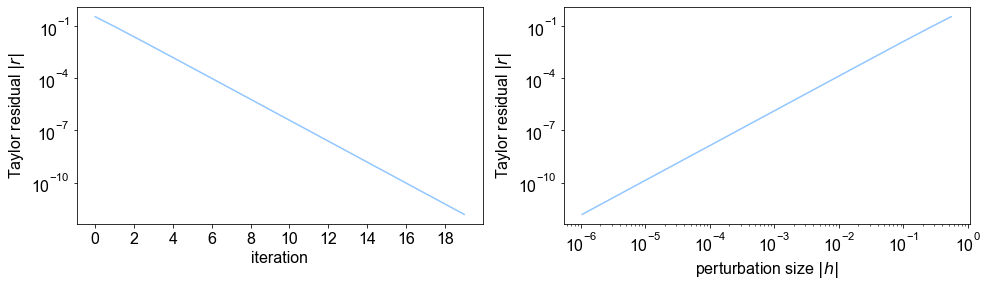

In [13]:
m = 2 #
np.random.seed(0)  #  (* see note 2 below)
h0 = np.random.random(1) #random initial perturbation 
# this not a small perturbation, but should show the asymptotic convergence for a sufficient number of iterations
taylor_test(u, dudm, m, h0)

<div class="optional">
The order of convergence, computed from subsequent iterations, rapidly reaches the expected value of 2.

# Question B9


The discrete version of the functional is given by:

$$
  f(\vec u) = \left(\vec u - \vec u_{\text{end}}\right)^T \left(\vec u - \vec u_{\text{end}}\right)
$$

and implemented below:

In [14]:
img1 = np.load('rsm-blurred.npy')
u_end = img1.flatten()
u1 = u(m) ## added by moi
def f(u):
    """Functional, return l2 norm error (misfit) between final timestep solution u and u_end"""
    return (u-u_end) @ (u-u_end)

we also define a little helper function that computes $f(\vec u(m))$:

In [15]:
def fhat(m):
    """Reduced functional, for given m evaluate the diffusion model to get u(m), and subtitute in functional."""
    return f(u(m))

* Write a python function `dfdm` that computes:
$$
  \frac{\mathrm{d}f(\vec u(m))}{\mathrm{d}m} = \left.\frac{\partial f(\vec u)}{\partial\vec u}\right|_{\vec u=\vec u(m)}\cdot\frac{\mathrm{d}\vec u}{\mathrm{d}m}
$$
Write a test that verifies the gradient is correct.

***

In [16]:
def dfdu(u):
    """Analytical derivative of the functional f(u)"""
    return 2*(u-u_end)
def dfdm(m):
    """Computes gradient dfdm"""
    return dfdu(u(m))@dudm(m) # dot product, equivalent to @

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.83529741 1.9105757  1.95324591 1.97607116 1.98789192 1.99390929
 1.99694538 1.99847036 1.9992346  1.99961711 1.99980863 1.99990421
 1.99995395 1.99997551 1.99992452 1.99995806 1.99980307 1.99912867
 1.99286123]


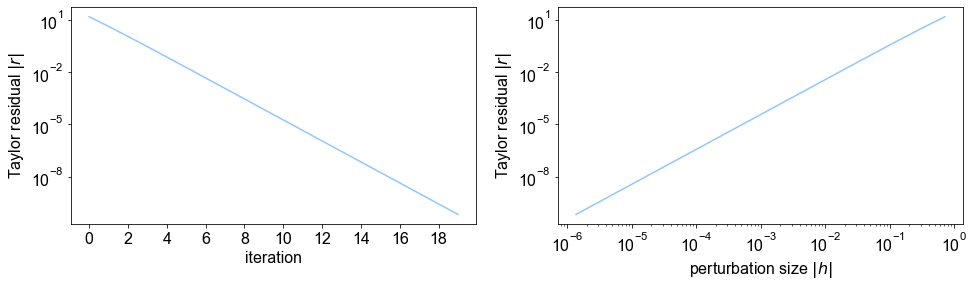

In [17]:
m = 2 # initial guess for diffusion coefficient
h0 = np.random.random(1) #random initial perturbation 
# this is not a small perturbation, but should show the asymptotic convergence for a sufficient number of iterations
taylor_test(fhat, dfdm, m, h0)

<div class="optional">
The order of convergence, computed from subsequent iterations, rapidly reaches the expected value of 2.

# Question B10

We decide to use the following minimisation algorithm:

In [18]:
def optimize(dfdm, m0):
    """Algorithm to find stationary point for f(m) by solving df(m)/dm=0
    
    dfdm: a function that returns the gradient of f
    m0: initial guess"""
    
    m_i = m0
    
    for i in range(100):  # fixed number of maximum iterations
        gradf_i = dfdm(m_i)
        print(dfdm(m_i)) # printed to check changes in slope
        # stopping criterion
        if abs(gradf_i) < 1e-5:
            break
        
        if i>0:
            # approximate the second derivative:
            hess = (gradf_i - gradf_prev) / (m_i - m_prev)
        else:
            # first step: no good approximation, but value should be
            # large enough to ensure the initial step is small
            hess = 100.
        
        # store previous values:
        gradf_prev = gradf_i
        m_prev = m_i
            
        # update step:
        m_i = m_prev - gradf_i/hess
        print('Iteration {}, value: {}'.format(i, m_i))
    else:
        print('Maximum number of iterations reached!')
        
    return m_i

In [19]:
optimize(dfdm, 3)

-3.6663146990524726
Iteration 0, value: 3.0366631469905245
-2.6731546704077744
Iteration 1, value: 3.1353443864513095
-0.15242222089987761
Iteration 2, value: 3.1413113877023555
-0.006782038423245066
Iteration 3, value: 3.141589253543142
-1.8168240371913935e-05
Iteration 4, value: 3.141589999910717
-2.1728483711579035e-09


3.141589999910717

* What is the specific name of the algorithm above, a variant of the Newton method? Why can we not use the standard Newton method? Use the above code to find the value of $m$ that was used to blur the photo. You will find that your initial guess needs to be roughly between 1 and 5. The algorithm does not converge for many values outside that range. Is this to be expected, and how could we improve it? (You do not need to actually implement this improvement)

<div class="optional">
    
The algorithm above corresponds to the secant method. 


Newton's method should not be used here as the derivative of the function being optimised cannot be calculated at each iteration. Whereas Newton’s method requires one function evaluation and one evaluation of the derivative per iteration, the secant method does not require evaluating the derivative [12].

The value of $m$ used to blur the photo is $\pi$ (around 3.14159).

The secant method might diverge -- in this case, it does so when using first guesses for $m$ out of the range $[1, 5]$. After drawing the first secant, the two resulting values can sometimes lie on the same side of the root. As a result, the method will diverge. Similarly, if the secant line is parallel to the x-axis (slope of 0), this will result in a divison by 0, making the method diverge as well. 

To overcome this issue, the secant method can be modified to the false position method (regula falsi). This method ensures that no two resulting values lie on the same side of the root by guessing and checking. By doing so, it brackets the root and is therefore guaranteed to converge. 



# Question B11

## Variable Diffusion Coefficient <a class="tocSkip"></a>
To apply a blur effect that varies throughout the photo, we consider a spatially varying diffusion coefficient $m(x,t)$

$$
  \frac{\partial u(x,y,t)}{\partial t} - m(x,t) \frac{\partial^2 u(x,y,t)}{\partial x^2} - m\frac{\partial^2 u(x,y,t)}{\partial y^2} = 0
$$

or in discretised form:
    
$$ 
\frac{u_i^{k+1} - u_i^k}{\Delta t} +
m_i\frac{-u_{i-1}^{k+1} + 2u_{i}^{k+1} -u_{i+1}^{k+1}}{\Delta x^2} + m_i\frac{-u_{i-N_x}^{k+1} + 2u_{i}^{k+1} - u_{i+N_x}^{k+1}}{\Delta y^2} = 0 $$

where $m_i$ are the entries of a vector $\vec m$ storing the different values of the diffusion coefficient at the grid points.

Again, we can write this as a linear system

$$
  \mat A \vec u^{k+1} = \vec u^k
$$

where now

$$
  \mat A = \mat I + \Delta t~\mat{diag}(\vec m)~\mat K
$$

with $\mat{diag}(\vec m)$ the diagonal matrix whose only nonzero entries are along the main diagonal, and are given by the entries of $\vec m$.

The implementation is given below:

In [20]:
def A_matrix(Nx, Ny, m, delta_t=1.0, delta_x=1.0):
    """Assemble discrete timestepping matrix A for diffusion equation
    with variable diffusion
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient in all gridpoints, array of length Nx*Ny
    delta_t: time step
    delta_x: grid distance
    """

    n = Ny * Nx
    K = K_matrix(Nx, Ny, delta_x)
    A = sp.eye(n) + delta_t * sp.diags(m) @  K
        
    return A

# added by moi

def K_matrix(Nx, Ny, delta_x=1.0):
    """Assemble discrete Poisson matrix K
    
    Nx, Ny: number of gridpoint in x and y directions
    delta_x: grid distance
    """
    n = Ny * Nx
    K = sp.eye(n)*4  # main diagonal with the value 4
    K -= sp.eye(n, k=1)  # connections to grid point on the right
    K -= sp.eye(n, k=-1)  # connection to the left
    K -= sp.eye(n, k=Nx) # connection to grid point below
    K -= sp.eye(n, k=-Nx)  # connection above
    K = K / (delta_x)**2  # divide all entries by dx^2
        
    return K

* Show that the matrix $\mat A$ is *not* symmetric (either by mathematical proof or by experiment), assuming the values of $\vec m$ are not all the same.

<div class="optional">
To illustrate this, take the simple case where:

$$\mat A = \mat I + \Delta t~\mat{diag}(\vec m)~\mat K = \mat I + \Delta t \begin{pmatrix}  
  m_{1,1} & 0 \\
  0 & m_{2,2}\\
  \end{pmatrix} 
  \begin{pmatrix}  
  K_{1,1} & K_{1,2} \\
  K_{2,1} & K_{2,2}\\
  \end{pmatrix} = \mat I + \Delta t~  \begin{pmatrix}  
  m_{1,1} K_{1,1} & m_{1,1} K_{1,2} \\
  m_{2,2} K_{2,1} & m_{2,2} K_{2,2}\\
  \end{pmatrix} = 
  \begin{pmatrix}  
  m_{1,1} K_{1,1} + I_{1,1} & m_{1,1} K_{1,2} \\
  m_{2,2} K_{2,1} & m_{2,2} K_{2,2} +  I_{2,2}\\
  \end{pmatrix}$$

The expression above shows that $\mat A$ is not symmetric for $m_{1,1} \neq m_{2,2}$.

This is also checked in the code below.  Random values of $m$ are generated to show how $\mat A$ is not symmetric. 

In [21]:
I = np.eye(2) # Initialise identitiy matrix
dt = 1e-2 # set some arbitrary dt
m = np.zeros((2, 2)); m[0, 0] = np.random.random(1); m[1, 1] = np.random.random(1) # set diagonal matrix m, where m1 != m2
K = K_matrix(1, 2) # intialise K matrix
A = I + dt*m@K # calculate A, and check it if it is symmetric
print("Matrix A is: \n {} \n Is it symmetric? {}".format(A, (np.count_nonzero(np.ndarray.flatten(A-A.transpose()))) == 0) )

Matrix A is: 
 [[ 1.02411054 -0.01205527]
 [-0.01089766  1.02179533]] 
 Is it symmetric? False


# Question B12

We now need to redefine the `diffusion_model` based on the new `A_matrix`. This code works exactly as before, except we now return not just the solution at the last timestep, but also all inbetween solutions in a list:

In [22]:
def diffusion_model(Nx, Ny, m, u0, Nt, delta_t=1.0, delta_x=1.0):
    """Solve diffusion equation with variable diffusion,
    and return the solution in all timesteps
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient in all gridpoints, array of length Nx*Ny
    u0: initial condition
    Nt: number of timesteps
    delta_t: time step
    delta_x: grid distance
    """

    A = A_matrix(Nx, Ny, m, delta_t=delta_t, delta_x=delta_x)
    u = []
    ui = u0
    for i in range(Nt):
        ui = spl.spsolve(A, ui)
        u.append(ui)
    return u

We use the model on a different photo, and run the model to apply the blurring effect.

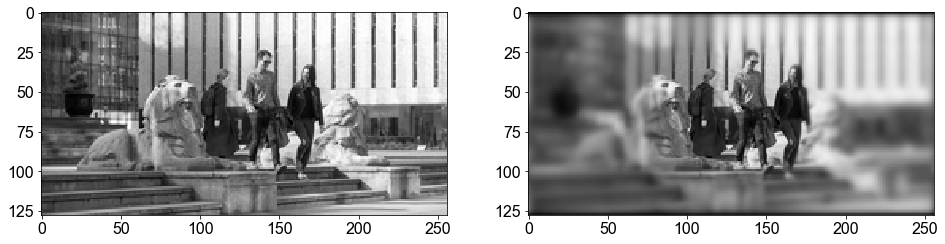

In [23]:
# read the input image, which forms the initial condition u_ic:
img = plt.imread('queens.png')
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(img, cmap='gray')

# This sets up the  spatially varying diffusion coefficient in an array m
# that increases towards the boundaries
# However, after this cell we will "forget" what m was, and try to retreive it
# by solving the optimisation problem described further below
Ny, Nx = img.shape
x, y = np.meshgrid(np.arange(Nx), np.arange(Ny))
x0 = Nx/2.; y0 = Ny/2.
m_grid = np.exp(-1/100./(((x-x0)/Nx/0.75)**4+((y-y0)/Ny/1.2)**4+1e-10))
m = m_grid.flatten()

# apply the filter based on this vector m:
u0 = img.flatten()
u = diffusion_model(Nx, Ny, m, u0, 5)

# plot the resulting image, and store it in a file to be used as u_end later
img1 = u[-1].reshape(img.shape)  # image based on the final timestep solution u[-1]
np.save('queens-blurred.npy', img1)
ax[1].imshow(img1, cmap='gray');

After applying the filter, again we have lost the vector of diffusion coefficients $\vec m$. Like before, we would like to recover these values using a PDE-constrained optimisation problem using the same functional $f(u, m)$ as before. This time we formulate it as a *discrete optimisation problem*:

$$
  \text{minimize } f(\vec u, \vec m) = \left(\vec u^{N_t}-\vec u_{\text{end}}\right)^T \left(\vec u^{N_t}-\vec u_{\text{end}}\right)
$$

subject to the discrete PDE constraint

$$
g(\vec u, \vec m) = 
\begin{pmatrix}
\mat A & 0 & 0 & 0 & \cdots & 0\\
-\mat I & \mat A & 0 & 0 &\cdots & 0\\
0 & -\mat I & \mat A & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \ddots & \cdots & 0 \\
0 & 0 & \cdots & -\mat I & \mat A & 0\\
0 & 0 & \cdots &0 & -\mat I & \mat A
\end{pmatrix}
\begin{pmatrix}
  \vec u^1 \\
  \vec u^2 \\
  \vec u^3 \\
  \vdots \\
  \vec u^{N_t-1} \\
  \vec u^{N_t}
\end{pmatrix}
-
\begin{pmatrix}
  \vec u_{\text{ic}} \\
  0 \\
  0 \\
  \vdots \\
  \phantom{^{N}} 0 \phantom{^{N}} \\
  \phantom{^{N}} 0 \phantom{^{N}}
\end{pmatrix}
=
\begin{pmatrix}
  0 \\
  0 \\
  0 \\
  \vdots \\
  \phantom{^{N}} 0 \phantom{^{N}} \\
  \phantom{^{N}} 0 \phantom{^{N}}
\end{pmatrix}  
$$

Here the vector $\vec u$ represents the entire discrete solution at all timesteps, and therefore has a length of $N_t\cdot N_x \cdot N_y$, and is composed of (sub)-vectors $\vec u^k$ for the solution at time-step $k$. The above matrix system thus describes the same timestepping sequence as we implemented above in `diffusion_model`:

$$
  \mat A\vec u^1 = \vec u_{\text{ic}} \\
  -\mat I\vec u^1 + \mat A\vec u^2 = 0  \implies  A\vec u^2 = \vec u^1 \\
  \vdots \\
  -\mat I\vec u^{N_t-1} + \mat A\vec u^{N_t} = 0  \implies  A\vec u^{N_t} = \vec u^{N_t-1}
$$

* We decide to solve this optimisation problem using a gradient-based optimisation algorithm, where the gradient is computed using the adjoint technique. Why can we not use the tangent linear approach as before (efficiently)? What are the three steps we need to take to compute this gradient?

<div class="optional">
The tangent linear method is useful for cases with a small number of parameters, and a potentially large number of functionals. The inversion problem stated above involves finding 128 different $m$ coefficients. Here  $𝑚$  represents an initial condition, and so the number of model parameters  𝑀  is the same as the number of gridpoints - which makes this method infeasible [10]. The problem above can be solved for each column in  𝑑𝑢/𝑑𝑚  separately with a corresponding column of  ∂𝑔/∂𝑚  on the right-hand side. Each of those  𝑀  solves is equivalent to running an entire discretised model through all its timesteps, making the tangent linear method highly suboptimal for this application. 

The gradient $d\hat f(m)/dm$ can be computed in 3 steps:

1. Solving the PDE constraint $g(u, m)=0$ to obtain $u=u(m)$

2. Solving the adjoint equation using $m$ and $u(m)$ for $\lambda$, such that the partial derivative of the Lagrangian with respect to **$u$** is zero. As such, the adjoint equation is given by:
$$
    \left(\frac{\partial g(u, \vec m)}{\partial u}\right)^T
  \vlam = \left(\frac{\partial f(u, \vec m)}{\partial u}\right)^T
$$

3. The derivative of the reduced functional is now given by:

$$
  \frac{d\hat f(\vec m)}{d\vec m} = \frac{\partial f(u, \vec m)}{\partial \vec m} - \vlam\cdot \frac{\partial g(u, \vec m)}{\partial \vec m}
$$

And for this particular problem: 

$$ \frac{\partial f(u, \vec m)}{\partial \vec m} = 0 $$

Which means that the derivative of the reduced functional can be described as: 
$$
  \frac{d\hat f(\vec m)}{d\vec m} = - \vlam\cdot \frac{\partial g(u, \vec m)}{\partial \vec m}
$$

In the last step, the term $\partial\mathcal{L}/\partial m$ is computed (this is not necessarily zero). $d\hat{f}/dm$ can be coputed such that the reduced optimisation problem is solved iteratively for $m$ [10]. Such an iterative solution procedure typicall requires the repetition of the three steps needed to compute the gradient for each iterate $m$. The optimal solution is found (some $m$ for which $d\hat{f}/dm=0$) as soon as the stationary point of $\mathcal{L}$ is calculated, since  $\partial\mathcal{L}/\partial m = d\hat{f}/dm=0$.

# Question B13

* Derive the (discrete) adjoint equation for this problem. Work out how the resulting linear system can be solved timestep by timestep. In what order are the timesteps best solved?

<div class="optional">
The process outlined below is similar to that found in [10].
    
The functional to be minimised is given by:
$$
f(\vec u, \vec m) = \left(\vec u^{N_t}-\vec u_{\text{end}}\right)^T \left(\vec u^{N_t}-\vec u_{\text{end}}\right)
$$

So its derivative is:

$$
\left(\frac{\partial f(u, \vec m)}{\partial u}\right) = 2\left(\vec u^{N_t}-\vec u_{\text{end}}\right)
$$


<div class="optional">
As stated above, the continuous adjoint equation is given by:

$$
    \left(\frac{\partial g(u, \vec m)}{\partial u}\right)^T
  \vlam = \left(\frac{\partial f(u, \vec m)}{\partial u}\right)^T = 2\left(\vec u^{N_t}-\vec u_{\text{end}}\right)
$$


<div class="optional">
Its discrete version can be expressed as: 

\begin{align*}
  \underset{\bf 1\times U}{\frac{\partial f(\vec u, \vec m)}{\partial\vec u}} - \underset{\bf 1\times U}{\lambda^T} 
  \underset{\bf U\times U}{\frac{\partial g(\vec u, \vec m)}{\partial\vec u}} = 0 \\
  \implies
  \underset{\bf U\times U}{\left(\frac{\partial g(\vec u, \vec m)}{\partial \vec u}\right)^T}
  \underset{\bf U\times 1}{\lambda} = \underset{\bf U\times 1}{\left(\frac{\partial f(\vec u,\vec m)}{\partial \vec u}\right)^T}
\end{align*}

By taking the transpose of the matrix $\partial g/\partial\vec u$ - in the tangent linear approach this matrix described a linearisation of the discretised PDE - an equation that can be solved for $\lambda$ is obtained.

<div class="optional">
Note that since $g(u, \vec m)=\mat A u - \vec b$ is linear, this becomes simply:

$$
    \mat A^T \vlam = \left(\frac{\partial f(u, \vec m)}{\partial u}\right)^T = 2\left(\vec u^{N_t}-\vec u_{\text{end}}\right)
$$


The adjoint equation gives rise to a linear system of the following form:

$$
  \begin{pmatrix}
    \mat A^T & \mat -I \\
    & \mat A^T & \mat -I \\
    & & \mat A^T & \mat -I \\
    & & & \ddots & \ddots \\
    & & & & \mat A^T & \mat -I \\
    & & & & & \mat A^T
  \end{pmatrix}
  \begin{pmatrix}
    \vlam^1 \\ \vlam^2 \\ \vlam^3 \\ \vdots \\ \vlam^{N_t-1} \\ \vlam^{N_t}
  \end{pmatrix}
=
  \begin{pmatrix}
    \frac{\partial f}{\partial \vec u^1} \\ 
    \frac{\partial f}{\partial \vec u^2} \\ 
    \frac{\partial f}{\partial \vec u^3} \\ 
    \vdots \\
    \frac{\partial f}{\partial \vec u^{N_t-1}} \\ 
    \frac{\partial f}{\partial \vec u^{N_t}} \\ 
  \end{pmatrix}
  =
  \begin{pmatrix}
   2(u^1 - u_{end})\\ 
   2(u^2 - u_{end})\\ 
   2(u^3 - u_{end}) \\ 
    \vdots \\
   2(u^{N_t-1} - u_{end})  \\ 
   2(u^{N_t} - u_{end})  \\ 
  \end{pmatrix},
$$

This system is solved by going backwards through the time levels, i.e. first the last row is solved:

$$
  \mat A_{N_t, N_t}^T \vlam^{N_t} = \frac{\partial f}{\partial \vec u^{N_t}} = 2(u^{N_t} - u_{end}),
$$

then using $\vlam^{N_t}$, solve for $\vlam^{N_t-1}$

$$
  \mat A_{N_t-1, N_t-1}^T \vlam^{N_t-1} - \mat I \vlam^{N_t}=  \frac{\partial f}{\partial \vec u^{N_t-1}} = 2(u^{N_t-1} - u_{end}),
$$

etc.

For a discrete PDE-constrained optimisation problem, the adjoint equation leads to a numerical model that requires the timesteps to be taken backwards.

# Question B14

We provide you with following code, implementing the backward model (which you should be able to relate to your previous answer):

In [24]:
def backward_model(Nx, Ny, m, Nt, u_Nt):
    """Solve adjoint equation and return the adjoint solution in all timesteps
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient in all gridpoints, array of length Nx*Ny
    u_Nt: forward solution in last timestep
    """

    A = A_matrix(Nx, Ny, m)
    lam = 2*(u_Nt - u_end)  # right-hand side in last time step
    
    # first collect solutions in reverse order:
    lambdas = []  
    for i in range(Nt):
        lam = spl.spsolve(A.T, lam)
        lambdas.append(lam)
    
    # then reverse the list, so that the returned list is in the correct order
    return lambdas[::-1]

In [25]:
# plot the resulting image, and store it in a file to be used as u_end later
img1 = u[-1].reshape(img.shape)  # image based on the final timestep solution u[-1]
np.save('queens-blurred.npy', img1)
ax[1].imshow(img1, cmap='gray');
#u_end

Again, we define

$$
  \hat f(\vec m) = f(\vec u(\vec m), \vec m)
$$

where $\vec u(\vec m)$ is the "forward" solution to the discretised PDE $g(\vec u,\vec m)=0$. This is implemented below:

In [26]:
img1 = np.load('queens-blurred.npy')
Ny, Nx = img1.shape
Nt = 5
u_end = img1.flatten()

def f(u_Nt):
    """Functional based on final-timestep forward solution"""
    return (u_Nt-u_end) @ (u_Nt-u_end)

def fhat(m):
    """Reduced functional: compute forward solution for given array of grid-point diffusion coefficients
    and subtitute into functional"""
    u = diffusion_model(Nx, Ny, m, u0, Nt)
    fu = f(u[-1])
    #print('f(u(m)): ', fu)
    return fu

* Implement the derivative $\mathrm{d}\hat f(\vec m)/\mathrm{d}\vec m$ in a python function `dfdm`. As always, test your derivative: i.e. write a test that verifies that `dfdm` is a derivative of `fhat` above.

**Hint**:
You may use the following expression:

\begin{align*}
  \left(\vlam^T \frac{\partial g(\vec u, \vec m)}{\partial\vec m}\right)_i
  =\sum_{k=1}^{N_t} \Delta t\lambda^k_i \left(\mat K\vec u^k\right)_i
\end{align*}

where $\lambda^k_i$ is the $i$ entry of the adjoint solution $\vlam^k$ at timestep $k$ (the $i$th entry in the $k$th array of the list of arrays returned by `backward_model`). Note that there is no summation over $i$ in the last expression: the shape of the matrix $\partial g/\partial\vec m$ is $(Nt\cdot n)\times n$, so $\vlam^T \partial g/\partial\vec m$ is a $n$-vector whose $i$-th entry is given above. Similarly $(\mat K\vec u^k)_i$ means the $i$-th entry of the vector given by the matrix-vector multiplication $\mat K\vec u^k$ where $\vec u^k$ is the solution in the $k$-th timestep (returned as a list of arrays by `diffusion_model`).

In [27]:
def dfdm(m, delta_t = 1):
    """Calculate dfdm (adjoint model). Takes list of diffusion coefficients m"""
    #step 1:
    u = diffusion_model(Nx, Ny, m, u0, Nt) 
    #step 2:
    lam = backward_model(Nx, Ny, m, Nt, u[-1][:])
    #step 3:
    df = np.zeros(Nx*Ny)
    for i in range(Nt):
        df = df - delta_t*lam[i][:]@K@u[i][:]
    return df

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.49346719 1.69400009 1.82939107 1.90950609 1.9533357  1.97629685
 1.98805347 1.99400271 1.99699532 1.99849614 1.99924769 1.99962375
 1.99981185 1.99990592 1.99995296 1.99997648 1.99998824 1.99999412
 1.99999706]


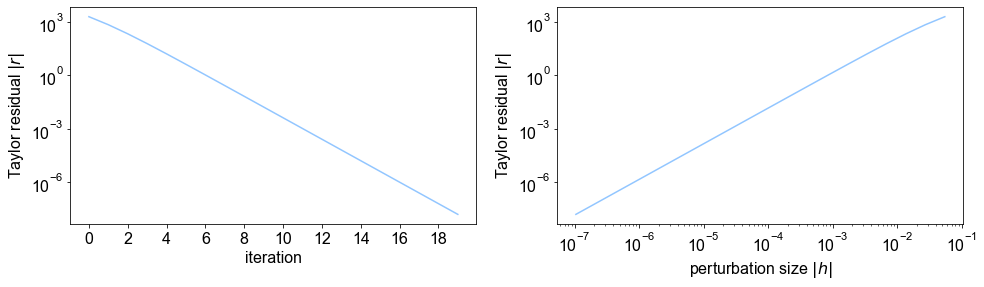

In [28]:
K = K_matrix(Nx, Ny) # initialise K matrix
m_grid = np.exp(-1/100./(((x-x0)/Nx/0.75)**4+((y-y0)/Ny/1.2)**4+1e-10)) # set some diffusion coefficients
m = m_grid.flatten() # and convert it to 1d array to pass it to functions
np.random.seed(0)  
h0 = np.random.random(1)/10 #set original perturbation
taylor_test(fhat, dfdm, m, h0) # test wether dfdm is indeed the derivative of fhat

<div class="optional">
The order of convergence, computed from subsequent iterations, rapidly reaches the expected value of 2.

# References 

[1] S. Kramer, "Lecture 5 - Jupyter Notebook", Imperial College, 2020.

[2] Math.mit.edu, 2020. [Online]. Available: https://math.mit.edu/classes/18.086/2006/am64.pdf. [Accessed: 11- Apr- 2020].

[3] People.inf.ethz.ch, 2020. [Online]. Available: http://people.inf.ethz.ch/arbenz/FEM17/pdfs/0-19-852868-X.pdf. [Accessed: 11- Apr- 2020].

[4] Web.stanford.edu, 2020. [Online]. Available: https://web.stanford.edu/class/cs205b/lectures/lecture16.pdf. [Accessed: 11- Apr- 2020].

[5] Math.utah.edu, 2020. [Online]. Available: https://www.math.utah.edu/~vshankar/5620/FDElliptic.pdf?fbclid=IwAR1MNdXD7_Be5AmAXgzQGECXwQGZxL3Ehdyy-MSeJOIjsZ1tWSoYKt6lb0g. [Accessed: 11- Apr- 2020].

[6] "Sparse matrix", En.wikipedia.org, 2020. [Online]. Available: https://en.wikipedia.org/wiki/Sparse_matrix. [Accessed: 11- Apr- 2020].

[7] Cs.nyu.edu, 2020. [Online]. Available: https://cs.nyu.edu/courses/fall06/G22.2112-001/linearAlgebra1.pdf. [Accessed: 11- Apr- 2020].

[8] Citeseerx.ist.psu.edu, 2020. [Online]. Available: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.231.4346&rep=rep1&type=pdf. [Accessed: 11- Apr- 2020].

[9] People.eecs.berkeley.edu, 2020. [Online]. Available: https://people.eecs.berkeley.edu/~wkahan/Math128/Projects/LamMath221.pdf. [Accessed: 11- Apr- 2020].

[10] S. Kramer, "Lecture 7 - Jupyter Notebook", Imperial College, 2020.

[11] S. Kramer, "Lecture 4 - Jupyter Notebook", Imperial College, 2020.

[12] Pages.cs.wisc.edu, 2020. [Online]. Available: http://pages.cs.wisc.edu/~amos/412/lecture-notes/lecture05.pdf. [Accessed: 11- Apr- 2020].